In [1]:
import warnings
import os
import time
import subprocess
from pathlib import Path
from math import gcd
from itertools import cycle
from collections import Counter
from functools import partial, lru_cache
from typing import List, Tuple, Optional, Dict, Any
import concurrent.futures
import tempfile
import numpy as np
from scipy import constants, spatial
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display

# Scientific computing imports
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.cif import CifWriter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from ase import io, Atoms
from io import StringIO
from ase.neighborlist import neighbor_list
from ase.io import read
from ase.data import atomic_masses
from ase.data import atomic_numbers
from ase.geometry import cellpar_to_cell
from ase.geometry import distance

# Configure warnings
warnings.filterwarnings("ignore", message="WARNING - doing cell minimisation without finite basis correction:")
warnings.filterwarnings("ignore", module="ase")

# Enable interactive plotting
%matplotlib widget

# --- Constants ---
DENSITY_CONVERSION_FACTOR = 1/(constants.N_A * 1e-24)  # AMU/A³ → g/cm³
meV_CONVERSION_FACTOR = 1000  # eV to meV
LOW_ENERGY_THRESHOLD = 30.0  # meV/atom
MAX_WORKERS = 8

# --- Configuration ---
class Config:
    """Configuration class for analysis parameters"""
    def __init__(self):
        self.relative_energies_on = True
        self.apply_cyanurate_filter = False
        self.apply_keep_octahedral = False
        self.apply_keep_tetrahedral = False
        self.apply_keep_layer = False
        self.apply_keep_chain = False
        self.do_low_energy_file = False
        self.vesta_path = r"C:\\VESTA-win64\\VESTA-win64\\VESTA.exe"
        self.convex_hull = False


class RESAnalyzer:
    """Main class for .res file analysis with optimized filtering"""
    
    def __init__(self, config: Config = None):
        self.config = config or Config()
        self.marker_cycle = cycle(['o', 's', '^', 'D', 'P', 'v', '<', '>', '*', 'X'])
        self.fu_to_color = {
            1: 'red', 2: 'green', 3: 'blue',
            4: 'purple', 6: 'magenta', 8: 'cyan',
            'other': 'black', 'Filtered out': 'lightgray'
        }
        # Cache for atomic masses to avoid repeated lookups
        self._atomic_mass_cache = {}
        self.failed_cif_files = []  # Track CIF creation failures
        
        # OPTIMIZATION: Cache for parsed structures to avoid re-reading
        self._structure_cache = {}
        self._neighbor_cache = {}
    
    @lru_cache(maxsize=128)
    def _get_atomic_mass(self, element: str) -> float:
        """Get atomic mass with LRU caching"""
        return atomic_masses[atomic_numbers[element]]
    
    def _get_cached_structure(self, file_path: Path) -> Optional[Atoms]:
        """Get cached structure or read and cache it"""
        if file_path in self._structure_cache:
            return self._structure_cache[file_path]
        
        try:
            with open(file_path, 'r') as f:
                content = f.read()
            
            # Use StringIO for in-memory processing
            atoms = read(StringIO(content), format='res')
            self._structure_cache[file_path] = atoms
            return atoms
        except Exception as e:
            print(f"Error reading structure from {file_path}: {e}")
            return None
    
    def _get_cached_neighbors(self, atoms: Atoms, cutoff: float) -> Dict[str, np.ndarray]:
        """Get cached neighbor list or compute and cache it"""
        # Create a simple hash for the atoms object based on positions and cell
        atoms_hash = hash((
            tuple(atoms.get_positions().flatten()),
            tuple(atoms.get_cell().flatten()) if atoms.cell is not None else (),
            tuple(atoms.get_chemical_symbols()),
            cutoff
        ))
        
        if atoms_hash in self._neighbor_cache:
            return self._neighbor_cache[atoms_hash]
        
        try:
            i, j, d = neighbor_list('ijd', atoms, cutoff=cutoff, self_interaction=False)
            neighbors = {'i': i, 'j': j, 'd': d}
            self._neighbor_cache[atoms_hash] = neighbors
            return neighbors
        except Exception:
            return {'i': np.array([]), 'j': np.array([]), 'd': np.array([])}
    
    def create_cif_from_file(self, file_path: Path) -> bool:
        """Create CIF file from input file with improved error handling and validation"""
        try:
            base_cif = file_path.with_suffix('.cif')
            
            with open(file_path, 'r') as f:
                content = f.read()

            tmp = tempfile.NamedTemporaryFile(mode='w+', suffix='.res', delete=False)
            try:
                tmp.write(content)
                tmp.close()  # Close so ASE can open it
                atoms = read(tmp.name, format='res')
            finally:
                os.unlink(tmp.name)  # Remove the temp file
            structure = AseAtomsAdaptor.get_structure(atoms)
            sym_structure = SpacegroupAnalyzer(
                structure, symprec=0.1
            ).get_symmetrized_structure()
            CifWriter(sym_structure, symprec=0.1).write_file(base_cif)
            return True
        except Exception as e:
            print(f"Error creating CIF from {file_path}: {e}")
            return False
    
    def _calculate_stoichiometry(self, atom_counts: Counter) -> str:
        """Calculate reduced stoichiometry from atom counts with validation"""
        if not atom_counts:
            return "?"
        
        # Remove any zero or negative counts
        valid_counts = {el: count for el, count in atom_counts.items() if count > 0}
        if not valid_counts:
            return "?"
        
        # More efficient calculation
        counts = list(valid_counts.values())
        if not counts:
            return "?"
        if len(counts) == 1:
            gcd_value = counts[0]
        else:
            gcd_value = counts[0]
            for count in counts[1:]:
                gcd_value = gcd(gcd_value, count)
        
        # Ensure gcd is at least 1
        if gcd_value <= 0:
            gcd_value = 1
        
        return ''.join(
            f"{el}{c // gcd_value if c // gcd_value > 1 else ''}" 
            for el, c in sorted(valid_counts.items())
        )
    
    def _get_gcd_from_atom_counts(self, atom_counts: Counter) -> int:
        """Get GCD from atom counts with validation"""
        if not atom_counts:
            return 1
        
        # Remove any zero or negative counts
        valid_counts = [count for count in atom_counts.values() if count > 0]
        if not valid_counts:
            return 1
        
        if len(valid_counts) == 1:
            return max(1, valid_counts[0])
        
        result = valid_counts[0]
        for count in valid_counts[1:]:
            result = gcd(result, count)
        
        return max(1, result)
    
    def parse_castep_file(self, file_path: Path) -> Dict[str, Any]:
        """Parse CASTEP file and extract relevant data with better validation"""
        try:
            with open(file_path, 'r') as f:
                content = f.read()

            tmp = tempfile.NamedTemporaryFile(mode='w+', suffix='.res', delete=False)
            try:
                tmp.write(content)
                tmp.close()  # Close so ASE can open it
                atoms = read(tmp.name, format='res')
            finally:
                os.unlink(tmp.name)  # Remove the temp file
            atom_counts = Counter(atoms.get_chemical_symbols())
            
            # Validate atom counts
            if not atom_counts or sum(atom_counts.values()) == 0:
                raise ValueError(f"No valid atoms found in {file_path}")
            
            number_of_atoms = sum(atom_counts.values())            
            enthalpies = []
            densities = []
            
            with open(file_path, 'r') as file:
                lines = file.readlines()
            
            for i, line in enumerate(lines):
                if "Final Enthalpy" in line:
                    parts = line.strip().split()
                    if len(parts) > 1:
                        try:
                            enthalpy_val = float(parts[-2])
                            # Sanity check for enthalpy values
                            if not (-100000 < enthalpy_val < 100000):  # Reasonable range in eV
                                print(f"Warning: Unusual enthalpy value {enthalpy_val} in {file_path}")
                            enthalpies.append(enthalpy_val)
                        except (ValueError, IndexError):
                            continue
                
                elif "density =" in line:
                    parts = line.strip().split()
                    if len(parts) > 2:
                        try:
                            density_val = float(parts[2])
                            # Sanity check for density values
                            if not (0.1 < density_val < 50):  # Reasonable range for solid density
                                print(f"Warning: Unusual density value {density_val} in {file_path}")
                            densities.append(density_val)
                        except (ValueError, IndexError):
                            continue
            
            if not enthalpies:
                raise ValueError(f"No enthalpy data found in {file_path}")
            if not densities:
                raise ValueError(f"No density data found in {file_path}")
            
            density = densities[-1] / DENSITY_CONVERSION_FACTOR  # AMU/A³ → g/cm³
            enthalpy = enthalpies[-1]
            energy_per_atom = (enthalpy * meV_CONVERSION_FACTOR) / number_of_atoms
            
            # Calculate stoichiometry
            stoichiometry = self._calculate_stoichiometry(atom_counts)
            
            return {
                'density': density,
                'energy_per_atom': energy_per_atom,
                'formula_units': self._get_gcd_from_atom_counts(atom_counts),
                'stoichiometry': stoichiometry,
            }
            
        except Exception as e:
            raise Exception(f"Error parsing {file_path}: {e}")
    
    def parse_res_file(self, file_path: Path) -> Dict[str, Any]:
        """
        Manually parse SHELX .res file with better atom detection and validation
        """
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
        except UnicodeDecodeError:
            # Try with different encoding
            with open(file_path, 'r', encoding='latin-1') as f:
                lines = f.readlines()
        
        if not lines:
            raise ValueError("Empty file")
        
        # Extract energy from TITL line (5th column)
        first_line = lines[0].strip().split()
        if len(first_line) < 5 or first_line[0] != "TITL":
            raise ValueError(f"Invalid TITL line: {lines[0].strip()}")
        
        try:
            energy = float(first_line[4])  # Energy in eV
            
            # Sanity check for energy values
            if not (-100000 < energy< -1000 ):
                print(f"Warning: Unusual energy value {energy} eV in {file_path}")
                print(first_line)
                try:
                    energy = float(first_line[5])  # Try next column if available
                except (ValueError, IndexError):
                    raise ValueError(f"Invalid energy value in TITL line: {first_line[5]}")
        except ValueError:
            raise ValueError(f"Could not extract energy from TITL line: {first_line[4]}")
        
        # Find and parse CELL line
        cell_line = None
        for line in lines:
            if line.startswith("CELL"):
                cell_line = line.strip().split()
                break
        
        if not cell_line or len(cell_line) < 8:
            raise ValueError("CELL line not found or invalid")
        
        try:
            # Skip wavelength (index 1), get cell parameters
            a, b, c = map(float, cell_line[2:5])
            alpha, beta, gamma = map(float, cell_line[5:8])
            
            # Validate cell parameters
            if not all(0.1 < param < 100 for param in [a, b, c]):
                raise ValueError(f"Invalid cell lengths: a={a}, b={b}, c={c}")
            if not all(10 < angle < 170 for angle in [alpha, beta, gamma]):
                raise ValueError(f"Invalid cell angles: α={alpha}, β={beta}, γ={gamma}")
                
        except ValueError as e:
            raise ValueError(f"Invalid cell parameters in CELL line: {cell_line}, error: {e}")
        
        # Parse SFAC line to get element types
        sfac_elements = []
        for line in lines:
            if line.startswith("SFAC"):
                parts = line.strip().split()[1:]  # Skip "SFAC"
                sfac_elements = [elem.strip() for elem in parts if elem.strip()]
                break
        
        # Parse atom positions with better element detection and validation
        atom_counts = Counter()
        positions = []
        
        for line in lines:
            line = line.strip()
            if not line or line.startswith('!'):  # Skip empty lines and comments
                continue
                
            parts = line.split()
            
            # Skip command lines
            if not parts or parts[0] in ['TITL', 'CELL', 'LATT', 'SYMM', 'SFAC', 'UNIT', 'END', 'HKLF']:
                continue
            
            # Check if this is an atom line
            if len(parts) >= 5:
                atom_name = parts[0]
                
                # Method 1: Try to extract element from atom name
                element = None
                
                # Remove numbers from the end and beginning
                clean_name = atom_name.strip('0123456789')
                
                if clean_name in atomic_numbers:
                    element = clean_name
                else:
                    # Try first 1-2 characters
                    for i in [2, 1]:
                        test_elem = clean_name[:i]
                        if test_elem in atomic_numbers:
                            element = test_elem
                            break
                
                # Method 2: If SFAC line exists, try to map using scattering factor number
                if not element and len(parts) >= 6 and sfac_elements:
                    try:
                        sfac_num = int(float(parts[1]))  # Scattering factor number
                        if 1 <= sfac_num <= len(sfac_elements):
                            element = sfac_elements[sfac_num - 1]
                    except (ValueError, IndexError):
                        pass
                
                if element and element in atomic_numbers:
                    try:
                        # Check coordinates (should be fractional, 0-1 range mostly)
                        x, y, z = map(float, parts[2:5])
                        
                        # Allow slightly outside 0-1 range due to symmetry operations
                        if -2 <= x <= 2 and -2 <= y <= 2 and -2 <= z <= 2:
                            # Get occupancy (default 1.0 if not specified)
                            occupancy = 1.0
                            if len(parts) >= 6:
                                try:
                                    occ_val = float(parts[5])
                                    if 0 < occ_val <= 1:
                                        occupancy = occ_val
                                    else:
                                        print(f"Warning: Invalid occupancy {occ_val} for atom {atom_name} in {file_path}")
                                except ValueError:
                                    pass
                            
                            atom_counts[element] += occupancy
                            positions.append([x, y, z])
                    except ValueError:
                        continue
        
        if not atom_counts:
            raise ValueError("No valid atoms found in file")
        
        # Round atom counts to nearest integer (handle fractional occupancies)
        rounded_counts = Counter()
        for element, count in atom_counts.items():
            if count <= 0:
                print(f"Warning: Non-positive atom count {count} for {element} in {file_path}")
                continue
            rounded_counts[element] = max(1, round(count))
        
        atom_counts = rounded_counts
        number_of_atoms = sum(atom_counts.values())
        
        if number_of_atoms == 0:
            raise ValueError("No atoms with positive counts found")
        
        # Calculate cell volume with validation
        alpha_rad = np.radians(alpha)
        beta_rad = np.radians(beta)
        gamma_rad = np.radians(gamma)
        
        cos_alpha = np.cos(alpha_rad)
        cos_beta = np.cos(beta_rad)
        cos_gamma = np.cos(gamma_rad)
        
        volume = a * b * c * np.sqrt(
            1 + 2*cos_alpha*cos_beta*cos_gamma - cos_alpha**2 - cos_beta**2 - cos_gamma**2
        ) # in Å³
        if volume <= 0:
            raise ValueError(f"Invalid cell volume: {volume}")
        
        if volume > 100000:  # Sanity check for very large volumes
            print(f"Warning: Very large cell volume {volume:.2f} Ų in {file_path}")
        
        # Calculate density
        total_mass = sum(self._get_atomic_mass(element) * count 
                        for element, count in atom_counts.items())
        
        density = (total_mass / volume) * DENSITY_CONVERSION_FACTOR
        
        
        # Calculate energy per atom
        energy_per_atom = (energy * meV_CONVERSION_FACTOR) / number_of_atoms
        
        # Calculate stoichiometry
        stoichiometry = self._calculate_stoichiometry(atom_counts)
        formula_units = self._get_gcd_from_atom_counts(atom_counts)

        # Create CIF file using validated atomic positions
        base_cif = file_path.with_suffix('.cif')
        out_cif = file_path.with_name(file_path.stem + '-out.cif')
        
        if not base_cif.exists() and not out_cif.exists():
            try:
                # Create atoms object with proper cell
                symbols = []
                coords = []
                
                for element, count in atom_counts.items():
                    # Add atoms based on count (simplified for CIF creation)
                    for i in range(int(count)):
                        if len(coords) < len(positions):
                            symbols.append(element)
                            coords.append(positions[len(coords)])
                
                if symbols and coords:
                    atoms = Atoms(
                        symbols=symbols,
                        scaled_positions=coords,
                        cell=cellpar_to_cell([a, b, c, alpha, beta, gamma]),
                        pbc=True
                    )
                    io.write(base_cif, atoms, format='cif')
            except Exception as e:
                print(f"Error writing CIF file for {file_path}: {e}")
                self.failed_cif_files.append(file_path)

        return {
            'density': density,
            'energy_per_atom': energy_per_atom,
            'formula_units': formula_units,
            'stoichiometry': stoichiometry,
        }
    
    def apply_structural_filters(self, file_path: Path) -> bool:
        """OPTIMIZED: Apply structural filters with caching and early returns"""
        try:
            # OPTIMIZATION 1: Early return if no filters are active
            active_filters = [
                self.config.apply_cyanurate_filter,
                self.config.apply_keep_octahedral,
                self.config.apply_keep_tetrahedral,
                self.config.apply_keep_layer,
                self.config.apply_keep_chain
            ]
            
            if not any(active_filters):
                return False

            # OPTIMIZATION 2: Use cached structure
            try:
                with open(file_path, 'r') as f:
                    content = f.read()

                with tempfile.NamedTemporaryFile(mode='w+', suffix='.res', delete=False) as tmp:
                    tmp.write(content)
                    tmp_path = tmp.name

                try:
                    atoms = read(tmp_path, format='res')
                finally:
                    os.unlink(tmp_path)
            except Exception:
                return False
                
            # OPTIMIZATION 3: Only compute neighbor lists for required cutoffs
            required_cutoffs = set()
            if self.config.apply_cyanurate_filter:
                required_cutoffs.add(1.8)
            if self.config.apply_keep_octahedral or self.config.apply_keep_tetrahedral:
                required_cutoffs.add(3.0)
            if self.config.apply_keep_layer or self.config.apply_keep_chain:
                required_cutoffs.add(2.8)

            # OPTIMIZATION 4: Compute only required neighbor lists with caching
            cutoff_map = {}
            for cutoff in required_cutoffs:
                cutoff_map[cutoff] = self._get_cached_neighbors(atoms, cutoff)

            # OPTIMIZATION 5: Order filters by computational cost (cheapest first)
            # This allows for early exits
            
            # Cheapest: Check for presence of specific elements first
            if self.config.apply_cyanurate_filter:
                symbols = atoms.get_chemical_symbols()
                if 'C' not in symbols:
                    # No carbon atoms, can't have cyanurate structure
                    pass
                elif self._has_cyanurate_structure(atoms, cutoff_map[1.8]):
                    return True
            
            if self.config.apply_keep_octahedral:
                symbols = atoms.get_chemical_symbols()
                if 'In' not in symbols:
                    # No indium atoms, filter passes
                    pass
                elif not self._has_octahedral_indium(atoms, cutoff_map[3.0]):
                    return True
            
            if self.config.apply_keep_tetrahedral:
                symbols = atoms.get_chemical_symbols()
                if 'In' not in symbols:
                    # No indium atoms, filter passes
                    pass
                elif not self._has_tetrahedral_indium(atoms, cutoff_map[3.0]):
                    return True
            
            # More expensive: Structural analysis
            if self.config.apply_keep_layer:
                if not self.is_layered_structure(atoms, cutoff_map[2.8]):
                    return True
            
            if self.config.apply_keep_chain:
                if not self.is_chain_structure(atoms, cutoff_map[2.8]):
                    return True

            return False

        except Exception as e:
            print(f"Error filtering {file_path}: {e}")
            return False

    def _has_cyanurate_structure(self, atoms, neighbors) -> bool:
        """OPTIMIZED: Check for cyanurate structure"""
        try:
            symbols = atoms.get_chemical_symbols()
            carbon_indices = [i for i, sym in enumerate(symbols) if sym == 'C']
            if not carbon_indices:
                return False
            
            # OPTIMIZATION: Use numpy for faster counting
            i_array = neighbors['i']
            if len(i_array) == 0:
                return False
            
            # Count coordination numbers only for carbon atoms
            carbon_coords = np.bincount(i_array[np.isin(i_array, carbon_indices)], 
                                      minlength=len(symbols))
            return np.any(carbon_coords[carbon_indices] > 2)
            
        except Exception:
            return False

    def _has_octahedral_indium(self, atoms, neighbors) -> bool:
        """OPTIMIZED: Check for octahedral indium"""
        try:
            symbols = np.array(atoms.get_chemical_symbols())
            indium_mask = symbols == 'In'
            if not np.any(indium_mask):
                return False
            
            i_array = neighbors['i']
            if len(i_array) == 0:
                return False
            
            # OPTIMIZATION: Use numpy operations
            indium_indices = np.where(indium_mask)[0]
            coordination = np.bincount(i_array, minlength=len(symbols))
            return np.any(coordination[indium_indices] == 6)
            
        except Exception:
            return False

    def _has_tetrahedral_indium(self, atoms, neighbors) -> bool:
        """OPTIMIZED: Check for tetrahedral indium"""
        try:
            symbols = np.array(atoms.get_chemical_symbols())
            indium_mask = symbols == 'In'
            if not np.any(indium_mask):
                return False
            
            i_array = neighbors['i']
            if len(i_array) == 0:
                return False
            
            # OPTIMIZATION: Use numpy operations
            indium_indices = np.where(indium_mask)[0]
            coordination = np.bincount(i_array, minlength=len(symbols))
            return np.any(coordination[indium_indices] == 4)
            
        except Exception:
            return False

    def is_layered_structure(self, atoms, neighbors) -> bool:
        """OPTIMIZED: Check if structure is 2D bonded (layered)"""
        try:
            i_list, j_list = neighbors['i'], neighbors['j']
            if len(i_list) == 0:
                return False
            
            # OPTIMIZATION: Vectorized distance calculation
            positions = atoms.get_positions()
            cell = atoms.get_cell()
            
            # Get bond vectors more efficiently
            bond_vectors = []
            for i, j in zip(i_list[:min(100, len(i_list))], j_list[:min(100, len(j_list))]):
                # Limit to first 100 bonds for speed
                vector = atoms.get_distance(i, j, vector=True)
                bond_vectors.append(vector)
            
            if not bond_vectors:
                return False
                
            bond_matrix = np.array(bond_vectors).T
            return np.linalg.matrix_rank(bond_matrix, tol=1e-10) == 2
            
        except Exception:
            return False

    def is_chain_structure(self, atoms, neighbors) -> bool:
        """OPTIMIZED: Check if structure is 1D bonded (chain)"""
        try:
            i_list, j_list = neighbors['i'], neighbors['j']
            if len(i_list) == 0:
                return False
            
            # OPTIMIZATION: Limit analysis to subset for speed
            bond_vectors = []
            for i, j in zip(i_list[:min(50, len(i_list))], j_list[:min(50, len(j_list))]):
                vector = atoms.get_distance(i, j, vector=True)
                bond_vectors.append(vector)
            
            if not bond_vectors:
                return False
                
            bond_matrix = np.array(bond_vectors).T
            return np.linalg.matrix_rank(bond_matrix, tol=1e-10) == 1
            
        except Exception:
            return False
    
    def process_single_file(self, file_path: Path) -> Tuple[Optional[Tuple], float]:
        """Process a single SHELX .res file with improved error handling"""
        start_time = time.time()
        
        try:
            # OPTIMIZATION: Check filters first before expensive CIF creation
            if self.apply_structural_filters(file_path):
                return None, time.time() - start_time
            
            # Create CIF if needed
            if not file_path.with_suffix('.cif').exists() and not file_path.with_name(file_path.stem + '-out.cif').exists():
                self.create_cif_from_file(file_path)
            
            # Parse file
            if file_path.suffix == '.castep':
                data = self.parse_castep_file(file_path)
            else:  
                data = self.parse_res_file(file_path)
            
            # Validate the parsed data
            if not all(key in data for key in ['density', 'energy_per_atom', 'formula_units', 'stoichiometry']):
                raise ValueError("Missing required data fields")
            
            if not isinstance(data['density'], (int, float)) or not isinstance(data['energy_per_atom'], (int, float)):
                raise ValueError("Invalid numeric data")
            
            if data['formula_units'] <= 0:
                raise ValueError("Invalid formula units")
            
            result = (
                file_path,
                data['density'],
                data['energy_per_atom'],
                data['formula_units'],
                data['stoichiometry']
            )
            
            return result, time.time() - start_time
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            return None, time.time() - start_time
    
    def copy_file_safe(self, src: Path, dst: Path) -> bool:
        """Safely copy file with error handling"""
        try:
            # Use shutil for more efficient file copying
            import shutil
            shutil.copy2(src, dst)
            return True
        except Exception as e:
            print(f"Copy failed for {src}: {e}")
            return False



    def densify_polyline_xy(self, xv, yv, N):
        xv = np.asarray(xv, dtype=float)
        yv = np.asarray(yv, dtype=float)

        # Sort by x
        order = np.argsort(xv)
        xv = xv[order]
        yv = yv[order]

        # Base grid
        x_dense = np.linspace(xv[0], xv[-1], N)

        # FORCE vertex x-values into grid
        x_all = np.unique(np.concatenate([x_dense, xv]))

        # Interpolate
        y_all = np.interp(x_all, xv, yv)

        return x_all, y_all
        
    def Create_convex_hull(self, densities: np.ndarray, energies: np.ndarray):
        """Create convex hull from densities and energies"""
        #make coppies of the arrys
        densities_plus= densities.copy()
        energies_plus= energies.copy()
        # add points to connect them to the axies 
        energies_plus=np.append(energies_plus,(1050, 1050))
        densities_plus=np.append(densities_plus,(0, 4))
        points = np.column_stack((densities_plus, energies_plus))

        #create convex hull 
        hull = spatial.ConvexHull(points)
        vertecies= hull.vertices
        hull_points=points[vertecies]
        hull_points= hull_points[np.argsort(hull_points[:,0])] # this is a sort based on the density values
        hull_desnity, hull_energies= self.densify_polyline_xy(hull_points[:,0], hull_points[:,1], len(densities_plus))

        return hull_energies, hull_desnity

    def save_low_energy_files(self, folder: Path, file_names: np.ndarray, 
                             relative_energies: np.ndarray, desities: np.ndarray) -> None:
        """Save low energy files to separate folder"""
        low_energy_folder = folder.parent / "low_energies_from_plot"
        low_energy_folder.mkdir(exist_ok=True)
        
        hull_energies , hull_densities= self.Create_convex_hull(desities, relative_energies)
        hull_energies= hull_energies+ LOW_ENERGY_THRESHOLD
        y_line_at_points = np.interp(desities, hull_densities, hull_energies)
        low_mask = relative_energies <= y_line_at_points
        low_indices = np.where(low_mask)[0]
        
        for idx in low_indices:
            src_res = file_names[idx]
            self.copy_file_safe(src_res, low_energy_folder / src_res.name)
            
            # Copy corresponding .cif file if exists
            cif_file = src_res.with_suffix('.cif')
            if cif_file.exists():
                self.copy_file_safe(cif_file, low_energy_folder / cif_file.name)

                
    
    def clear_caches(self):
        """Clear internal caches to free memory"""
        self._structure_cache.clear()
        self._neighbor_cache.clear()

    def process_folder(self, folder: Path) -> Tuple[np.ndarray, ...]:
        """OPTIMIZED: Process all SHELX .res files in folder with batch processing"""
        # More comprehensive file search
        res_files = []
        
        # Search for .res files recursively
        for pattern in ['*.res', '*.RES']:  # Case insensitive search
            res_files.extend(list(folder.rglob(pattern)))
        
        # Remove duplicates while preserving order
        seen = set()
        unique_files = []
        for f in res_files:
            if f not in seen:
                seen.add(f)
                unique_files.append(f)
        
        res_files = unique_files
        print(f"Found {len(res_files)} .res files")
        
        if not res_files:
            print("No .res files found!")
            return tuple()
        
        # OPTIMIZATION: Pre-filter files if any filters are active
        if any([self.config.apply_cyanurate_filter, self.config.apply_keep_octahedral,
                self.config.apply_keep_tetrahedral, self.config.apply_keep_layer,
                self.config.apply_keep_chain]):
            
            print("Pre-filtering files...")
            filtered_files = []
            filter_start = time.time()
            
            # OPTIMIZATION: Use smaller thread pool for I/O bound filtering
            with concurrent.futures.ThreadPoolExecutor(max_workers=min(4, MAX_WORKERS)) as executor:
                # Create filter tasks
                filter_futures = {
                    executor.submit(self.apply_structural_filters, f): f 
                    for f in res_files
                }
                
                for future in tqdm(concurrent.futures.as_completed(filter_futures), 
                                total=len(filter_futures), desc="Filtering files"):
                    file_path = filter_futures[future]
                    try:
                        is_filtered = future.result()
                        if not is_filtered:
                            filtered_files.append(file_path)
                    except Exception as e:
                        print(f"Filter error for {file_path}: {e}")
                        # Include file if filtering fails
                        filtered_files.append(file_path)
            
            filter_time = time.time() - filter_start
            print(f"Filtered {len(res_files)} -> {len(filtered_files)} files in {filter_time:.2f}s")
            res_files = filtered_files
            
            # OPTIMIZATION: Clear caches after filtering to free memory
            if len(self._structure_cache) > 100:  # Only clear if cache is large
                print("Clearing structure cache...")
                self.clear_caches()
        
        if not res_files:
            print("All files were filtered out!")
            return tuple()
        
        results = []
        times = []
        failed_files = []
        
        process_fn = partial(self.process_single_file)
        total_start = time.time()
        
        # OPTIMIZATION: Batch processing with memory management
        batch_size = min(1000, len(res_files))  # Process in batches to manage memory
        
        for batch_start in range(0, len(res_files), batch_size):
            batch_end = min(batch_start + batch_size, len(res_files))
            batch_files = res_files[batch_start:batch_end]
            
            print(f"Processing batch {batch_start//batch_size + 1}/{(len(res_files)-1)//batch_size + 1}")
            
            with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
                futures = [executor.submit(process_fn, file_path) for file_path in batch_files]
                
                for i, future in enumerate(tqdm(concurrent.futures.as_completed(futures), 
                                total=len(batch_files), desc=f"Processing batch")):
                    result, duration = future.result()
                    if result is None:
                        failed_files.append(batch_files[i])
                        continue
                    else:
                        results.append(result)
                        times.append(duration)
            
            # OPTIMIZATION: Clear caches between batches if they get too large
            if len(self._structure_cache) > 500:
                self.clear_caches()
        
        total_duration = time.time() - total_start
        
        print(f"Successfully processed: {len(results)} files")
        print(f"Failed to process: {len(failed_files)} files")
        
        if self.failed_cif_files:
            print(f"Failed to create CIF files for: {len(self.failed_cif_files)} files")
        
        if not results:
            print("No valid data processed.")
            if failed_files:
                print("Sample failed files:")
                for f in failed_files[:5]:
                    print(f"  {f}")
            return tuple()
        
        # Print statistics
        self._print_processing_stats(len(results), total_duration, times)
        
        # OPTIMIZATION: Final cache cleanup
        self.clear_caches()
        
        # Unpack results more efficiently
        file_names, densities, energies, formula_units, stoichiometries = zip(*results)
        
        # Convert to numpy arrays
        file_names = np.array(file_names, dtype='object')
        densities = np.array(densities, dtype='float64')
        energies = np.array(energies, dtype='float64')
        formula_units = np.array(formula_units, dtype='int32')
        stoichiometries = np.array(stoichiometries, dtype='object')
        
        # Calculate relative energies if needed (EACH FOLDER INDEPENDENTLY)
        if self.config.relative_energies_on:
            min_energy = energies.min()
            relative_energies = energies - min_energy
            
            if self.config.do_low_energy_file:
                self.save_low_energy_files(folder, file_names, relative_energies, densities)
            return file_names, densities, relative_energies, formula_units, stoichiometries
        else:
            if self.config.do_low_energy_file:
                self.save_low_energy_files(folder, file_names, energies, densities)
            return file_names, densities, energies, formula_units, stoichiometries


    def process_multiple_folders(self, folders: List[Path]) -> Dict[str, Tuple[np.ndarray, ...]]:
        """
        Process multiple folders and return results separately with globally relative energies.
        
        Args:
            folders: List of Path objects pointing to folders containing .res files
            
        Returns:
            Dictionary mapping folder names to tuples of (file_names, densities, energies, formula_units, stoichiometries)
            where energies are relative to the global minimum across all folders
        """
        if not folders:
            print("No folders provided!")
            return {}
        
        print(f"\n{'='*60}")
        print(f"Processing {len(folders)} folders")
        print(f"{'='*60}\n")
        
        # Process each folder individually
        folder_results = {}
        all_energies = []
        
        for i, folder in enumerate(folders, 1):
            print(f"\n--- Folder {i}/{len(folders)}: {folder} ---")
            
            result = self.process_folder(folder)
            
            if result:  # Only store if processing was successful
                folder_name = folder.name
                folder_results[folder_name] = result
                
                # Collect energies for global minimum calculation
                _, _, energies, _, _ = result
                all_energies.extend(energies)
        
        if not folder_results:
            print("\nNo valid data processed from any folder!")
            return {}
        
        print(f"\n{'='*60}")
        print(f"Computing global relative energies")
        print(f"{'='*60}")
        
        # Find global minimum energy across all folders
        global_min_energy = min(all_energies)
        print(f"Global minimum energy: {global_min_energy:.6f}")
        
        # Apply relative energies to each folder's results
        final_results = {}
        
        for folder_name, (file_names, densities, energies, formula_units, stoichiometries) in folder_results.items():
            if self.config.relative_energies_on:
                relative_energies = energies - global_min_energy
                print(f"{folder_name}: Energy range = {relative_energies.min():.6f} to {relative_energies.max():.6f}")
                
                if self.config.do_low_energy_file:
                    # Reconstruct folder path from results
                    folder_path = Path(file_names[0]).parent
                    while folder_path.name != folder_name and folder_path.parent != folder_path:
                        folder_path = folder_path.parent
                    self.save_low_energy_files(folder_path, file_names, relative_energies, densities)
                
                final_results[folder_name] = (file_names, densities, relative_energies, formula_units, stoichiometries)
            else:
                if self.config.do_low_energy_file:
                    folder_path = Path(file_names[0]).parent
                    while folder_path.name != folder_name and folder_path.parent != folder_path:
                        folder_path = folder_path.parent
                    self.save_low_energy_files(folder_path, file_names, energies, densities)
                
                final_results[folder_name] = (file_names, densities, energies, formula_units, stoichiometries)
        
        print(f"\n{'='*60}")
        print(f"Processing complete!")
        print(f"Total folders processed: {len(final_results)}")
        print(f"{'='*60}\n")
        
        return final_results

    
    def _print_processing_stats(self, num_files: int, total_duration: float, times: List[float]) -> None:
        """Print processing statistics"""
        avg_time = sum(times) / len(times) if times else 0
        print(f"\n✅ Processed {num_files} files")
        print(f"⏱️ Total time: {total_duration:.2f} seconds")
        print(f"⏱️ Average time per file: {avg_time:.3f} seconds")
        print(f"⏱️ Files per second: {num_files / total_duration:.2f}")
    

    def create_interactive_plot(self, file_names: np.ndarray, energies: np.ndarray, 
                            densities: np.ndarray, formula_units: np.ndarray, 
                            stoichiometries: np.ndarray) -> None:
        """Create interactive plot with corrected hover labels"""
        # Create marker mapping
        unique_stoichiometries = sorted(set(stoichiometries))
        stoich_to_marker = {stoich: next(self.marker_cycle) for stoich in unique_stoichiometries}
        
        # Group data
        fu_labels = np.array([
            fu if fu in self.fu_to_color else 'other' 
            for fu in formula_units
        ])
        
        group_keys = np.array([f"{s}_{fu}" for s, fu in zip(stoichiometries, fu_labels)])
        unique_groups = np.unique(group_keys)
        
        grouped = {}
        for group in unique_groups:
            mask = group_keys == group
            indices = np.where(mask)[0]
            stoich, fu_label = group.rsplit('_', 1)
            grouped[(stoich, fu_label)] = indices
        
        hull_energies, hull_densities = self.Create_convex_hull(densities=densities, energies=energies)
        possible_energies= hull_energies+30


        # Create plot
        fig, ax = plt.subplots(figsize=(10, 6))
        plt.subplots_adjust(right=0.75)
        
        scatter_points = []
        ax.plot(hull_densities, hull_energies, label= 'Convex hull plot', c='k', linestyle= '--')
        ax.plot(hull_densities, possible_energies, label= '30 meV/atom above hull', c='r', linestyle= '--')
        for (stoich, fu_label), idxs in grouped.items():
            marker = stoich_to_marker[stoich]
            if fu_label == 'Filtered out':
                color = self.fu_to_color['Filtered out']
            else:
                try:
                    fu_int = int(fu_label)
                    color = self.fu_to_color.get(fu_int, self.fu_to_color['other'])
                except ValueError:
                    color = self.fu_to_color['other']
            alpha = 0.8 if fu_label != 'Filtered out' else 0.5
            size = 60 if fu_label != 'Filtered out' else 30
            sc = ax.scatter(
                densities[idxs], energies[idxs],
                marker=marker, color=color, alpha=alpha,
                label=f"{stoich} | {fu_label} FU", picker=True, s=size ,edgecolors='black', linewidth=0.5
            )
            scatter_points.append((sc, idxs))
        
        # Add legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(
            by_label.values(), by_label.keys(),
            loc='upper left', bbox_to_anchor=(1.05, 1),
            title="Stoichiometry | F.U."
        )
        
        # Set labels with correct energy type
        ax.set_xlabel('Density (g/cm³)')
        ylabel = ('Relative energy (meV/atom)' if self.config.relative_energies_on 
                else 'Energy per atom (meV/atom)')
        ax.set_ylabel(ylabel)
        
        # Add interactivity with corrected labels
        self._add_plot_interactivity(fig, ax, scatter_points, file_names, 
                                        densities, energies, stoichiometries, fu_labels)
        
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0,4)
        ax.set_ylim(min(energies)-10, max(energies)+10)
        plt.tight_layout()
        plt.show()
    

    def create_comparison_plot(self, 
                        file_names_1: np.ndarray, energies_1: np.ndarray,
                        densities_1: np.ndarray, formula_units_1: np.ndarray,
                        stoichiometries_1: np.ndarray,
                        file_names_2: np.ndarray, energies_2: np.ndarray,
                        densities_2: np.ndarray, formula_units_2: np.ndarray,
                        stoichiometries_2: np.ndarray) -> None:
        """Create interactive comparison plot with arrows between matching filenames"""
    
        # Create marker mapping (combine both sets for consistency)
        all_stoichiometries = sorted(set(list(stoichiometries_1) + list(stoichiometries_2)))
        stoich_to_marker = {stoich: next(self.marker_cycle) for stoich in all_stoichiometries}
        
        # Create figure
        fig, ax = plt.subplots(figsize=(12, 7))
        plt.subplots_adjust(right=0.75)
        
        scatter_points = []
        
        # Plot Dataset 1 with filled markers
        fu_labels_1 = np.array([
            fu if fu in self.fu_to_color else 'other' 
            for fu in formula_units_1
        ])
        
        group_keys_1 = np.array([f"{s}_{fu}" for s, fu in zip(stoichiometries_1, fu_labels_1)])
        unique_groups_1 = np.unique(group_keys_1)
        
        grouped_1 = {}
        for group in unique_groups_1:
            mask = group_keys_1 == group
            indices = np.where(mask)[0]
            stoich, fu_label = group.rsplit('_', 1)
            grouped_1[(stoich, fu_label)] = indices
        
        for (stoich, fu_label), idxs in grouped_1.items():
            marker = stoich_to_marker[stoich]
            if fu_label == 'Filtered out':
                color = self.fu_to_color['Filtered out']
            else:
                try:
                    fu_int = int(fu_label)
                    color = self.fu_to_color.get(fu_int, self.fu_to_color['other'])
                except ValueError:
                    color = self.fu_to_color['other']
            
            alpha = 0.8 if fu_label != 'Filtered out' else 0.5
            size = 60 if fu_label != 'Filtered out' else 30
            
            sc = ax.scatter(
                densities_1[idxs], energies_1[idxs],
                marker=marker, color=color, alpha=alpha,
                label=f"{stoich} | {fu_label} FU | Set 1", 
                picker=True, s=size, edgecolors='black', linewidth=0.5
            )
            scatter_points.append((sc, idxs))
        
        # Plot Dataset 2 with hollow/outlined markers
        fu_labels_2 = np.array([
            fu if fu in self.fu_to_color else 'other' 
            for fu in formula_units_2
        ])

        group_keys_2 = np.array([f"{s}_{fu}" for s, fu in zip(stoichiometries_2, fu_labels_2)])
        unique_groups_2 = np.unique(group_keys_2)
        
        grouped_2 = {}
        for group in unique_groups_2:
            mask = group_keys_2 == group
            indices = np.where(mask)[0]
            stoich, fu_label = group.rsplit('_', 1)
            grouped_2[(stoich, fu_label)] = indices
        
        offset = len(file_names_1)  # Offset for indexing in combined arrays
        
        for (stoich, fu_label), idxs in grouped_2.items():
            marker = stoich_to_marker[stoich]
            if fu_label == 'Filtered out':
                color = self.fu_to_color['Filtered out']
            else:
                try:
                    fu_int = int(fu_label)
                    color = self.fu_to_color.get(fu_int, self.fu_to_color['other'])
                except ValueError:
                    color = self.fu_to_color['other']
            
            alpha = 0.8 if fu_label != 'Filtered out' else 0.5
            size = 60 if fu_label != 'Filtered out' else 30
            
            # Use facecolors='none' to make hollow markers
            sc = ax.scatter(
                densities_2[idxs], energies_2[idxs],
                marker=marker, facecolors='none', edgecolors=color, alpha=alpha,
                label=f"{stoich} | {fu_label} FU | Set 2", 
                picker=True, s=size, linewidth=2
            )
            scatter_points.append((sc, idxs + offset))
        
        # # Plot convex hulls for both sets
        # hull_energies_1, hull_densities_1 = self.Create_convex_hull(densities=densities_1, energies=energies_1)
        # hull_energies_2, hull_densities_2 = self.Create_convex_hull(densities=densities_2, energies=energies_2)
        
        # ax.plot(hull_densities_1, hull_energies_1, label='Convex hull (Set 1)', 
        #         c='blue', linestyle='--', linewidth=2)
        # ax.plot(hull_densities_2, hull_energies_2, label='Convex hull (Set 2)', 
        #         c='red', linestyle='--', linewidth=2)
        
        # Draw arrows between matching filenames with improved matching
        # Convert Path objects to strings explicitly and extract basenames
        basenames_1 = {}
        for i, path_obj in enumerate(file_names_1):
            basename = Path(path_obj).name  # Get just the filename
            basenames_1[basename] = (densities_1[i], energies_1[i])
        
        basenames_2 = {}
        for i, path_obj in enumerate(file_names_2):
            basename = Path(path_obj).name  # Get just the filename
            basenames_2[basename] = (densities_2[i], energies_2[i])
        
        # Find matching filenames
        matching_files = set(basenames_1.keys()) & set(basenames_2.keys())
        
        print(f"\nArrow Drawing Debug Info:")
        print(f"Dataset 1: {len(basenames_1)} unique files")
        print(f"Dataset 2: {len(basenames_2)} unique files")
        print(f"Matching files: {len(matching_files)}")
        
        if matching_files:
            print(f"\nSample matching files (first 5):")
            for filename in list(matching_files)[:5]:
                x1, y1 = basenames_1[filename]
                x2, y2 = basenames_2[filename]
                print(f"  {filename}: ({x1:.2f}, {y1:.2f}) -> ({x2:.2f}, {y2:.2f})")
        
        # Draw arrows for matching files
        arrow_count = 0
        for filename in matching_files:
            x1, y1 = basenames_1[filename]
            x2, y2 = basenames_2[filename]
            
            # Calculate distance to avoid drawing arrows for identical points
            distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            
            if distance > 0.01:  # Only draw arrow if points are different
                ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                        arrowprops=dict(arrowstyle='->', color='gray', 
                                        alpha=0.8, lw=1.5, 
                                        connectionstyle='arc3,rad=0'))
                arrow_count += 1
        
        print(f"Arrows drawn: {arrow_count}")
        
        if arrow_count > 0:
            # Add a legend entry for the arrows
            ax.plot([], [], color='gray', linestyle='-', linewidth=1.5, 
                label=f'Structure transitions ({arrow_count})')
        
        # Add legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(
            by_label.values(), by_label.keys(),
            loc='upper left', bbox_to_anchor=(1.05, 1),
            title="Stoichiometry | F.U. | Dataset"
        )
        
        # Set labels
        ax.set_xlabel('Density (g/cm³)')
        ylabel = ('Relative energy (meV/atom)' if self.config.relative_energies_on 
                else 'Energy per atom (meV/atom)')
        ax.set_ylabel(ylabel)
        
        # Add interactivity
        all_file_names = np.concatenate([file_names_1, file_names_2])
        all_densities = np.concatenate([densities_1, densities_2])
        all_energies = np.concatenate([energies_1, energies_2])
        all_stoichiometries = np.concatenate([stoichiometries_1, stoichiometries_2])
        all_fu_labels = np.concatenate([fu_labels_1, fu_labels_2])
        
        self._add_plot_interactivity(fig, ax, scatter_points, all_file_names,
                                    all_densities, all_energies, all_stoichiometries, all_fu_labels)
        
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 4)
        all_energies_combined = np.concatenate([energies_1, energies_2])
        ax.set_ylim(min(all_energies_combined)-10, max(all_energies_combined)+10)
        plt.tight_layout()
        plt.show() 
  

    def _add_plot_interactivity(self, fig, ax, scatter_points, file_names, 
                                 densities, energies, stoichiometries, fu_labels):
        """Fixed interactivity with correct energy labels"""
        # Determine energy label based on configuration
        energy_label = "Relative E" if self.config.relative_energies_on else "E"
        
        # Pre-compute hover labels with correct energy values
        hover_labels = [
            f"{p.name}\nρ = {d:.2f} g/cm³\n{energy_label} = {e:.4f} meV/atom\n{st} | {fu} FU"
            for p, d, e, st, fu in zip(file_names, densities, energies, 
                                    stoichiometries, fu_labels)
        ]
        
        annot = ax.annotate("", xy=(0, 0), xytext=(-40, 10), 
                        textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w", alpha=0.9),
                        arrowprops=dict(arrowstyle="->"))
        annot.set_visible(False)
    
        def update_annot(ind):
            idx = ind["ind"][0]
            annot.xy = (densities[idx], energies[idx])
            annot.set_text(hover_labels[idx])
        
        def on_motion(event):
            if event.inaxes == ax:
                found_point = False
                for sc, idxs in scatter_points:
                    cont, ind = sc.contains(event)
                    if cont:
                        global_idx = idxs[ind['ind'][0]]
                        update_annot({'ind': [global_idx]})
                        annot.set_visible(True)
                        fig.canvas.draw_idle()
                        found_point = True
                        break
                
                if not found_point and annot.get_visible():
                    annot.set_visible(False)
                    fig.canvas.draw_idle()
            else:
                if annot.get_visible():
                    annot.set_visible(False)
                    fig.canvas.draw_idle()
        
        fig.canvas.mpl_connect("motion_notify_event", on_motion)
        
        # Add other interactive features
        self._add_search_widget(fig, ax, densities, energies, stoichiometries, file_names)
        self._add_vesta_functionality(fig, ax, scatter_points, file_names)
    
    def _add_search_widget(self, fig, ax, densities, energies, stoichiometries, file_names):
        """Add search widget functionality"""
        search_box = widgets.Text(
            value='',
            placeholder='Enter filename or stoichiometry',
            description='Search:',
            disabled=False
        )
        display(search_box)
        
        highlight_scatter = [None]
        
        def search_and_highlight(change):
            term = change['new'].strip().lower()
            if highlight_scatter[0]:
                highlight_scatter[0].remove()
                highlight_scatter[0] = None
            
            if not term:
                fig.canvas.draw_idle()
                return
            
            # More efficient search
            matches = []
            
            # First try exact stoichiometry match
            for i, stoich in enumerate(stoichiometries):
                if term == stoich.lower():
                    matches.append(i)
            
            # If no exact matches, try partial matches
            if not matches:
                for i, (fname, stoich) in enumerate(zip(file_names, stoichiometries)):
                    if term in str(fname).lower() or term in stoich.lower():
                        matches.append(i)
            
            if matches:
                x = densities[matches]
                y = energies[matches]
                highlight_scatter[0] = ax.scatter(
                    x, y, s=200, facecolors='none',
                    edgecolors='orange', linewidths=2, label='Search Result'
                )
                fig.canvas.draw_idle()
        
        search_box.observe(search_and_highlight, names='value')
    
    def _add_vesta_functionality(self, fig, ax, scatter_points, file_names):
        """Add double-click to open in VESTA functionality"""
        def on_click(event):
            if event.inaxes != ax or not event.dblclick:
                return
            
            for sc, idxs in scatter_points:
                contains, attr = sc.contains(event)
                if contains:
                    ind = attr['ind'][0]
                    global_idx = idxs[ind]
                    
                    # Try both .cif and -out.cif files
                    cif_path = file_names[global_idx].with_suffix('.cif')
                    out_cif_path = file_names[global_idx].with_name(
                        file_names[global_idx].stem + '-out.cif'
                    )
                    
                    # Check which CIF file exists
                    if out_cif_path.exists():
                        target_cif = out_cif_path
                    elif cif_path.exists():
                        target_cif = cif_path
                    else:
                        print(f"No CIF file found for {file_names[global_idx]}")
                        return
                    
                    try:
                        subprocess.Popen([self.config.vesta_path, str(target_cif)])
                        print(f"Opened {target_cif} in VESTA")
                    except FileNotFoundError:
                        print(f"VESTA executable not found at: {self.config.vesta_path}")
                        print("Please check the VESTA path in the configuration.")
                    except Exception as e:
                        print(f"Error opening VESTA: {e}")
                    return
        
        fig.canvas.mpl_connect('button_press_event', on_click)





🚀 Starting optimized analysis...
Found 2703 .res files
Pre-filtering files...


Filtering files:   0%|          | 0/2703 [00:00<?, ?it/s]

Filtered 2703 -> 2179 files in 25.25s
Processing batch 1/3


Processing batch:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing batch 2/3


Processing batch:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing batch 3/3


Processing batch:   0%|          | 0/179 [00:00<?, ?it/s]

Successfully processed: 2179 files
Failed to process: 0 files

✅ Processed 2179 files
⏱️ Total time: 7.67 seconds
⏱️ Average time per file: 0.028 seconds
⏱️ Files per second: 284.10
🎉 Total analysis completed in 34.67159914970398 seconds


Text(value='', description='Search:', placeholder='Enter filename or stoichiometry')

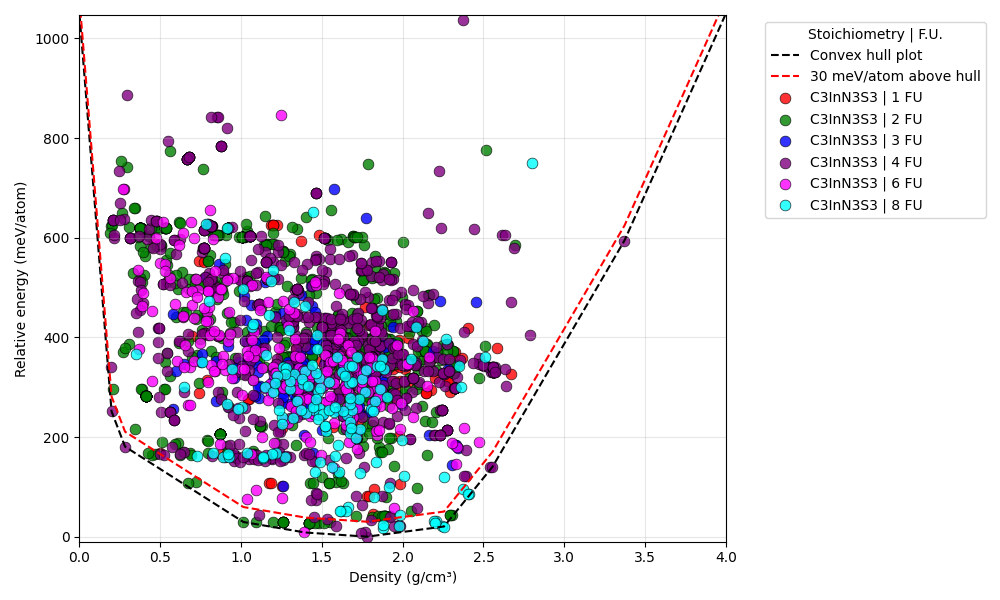

In [2]:

"""Main execution function with optimizations"""
# Configuration
config = Config()
config.relative_energies_on = True
config.apply_cyanurate_filter = True
config.apply_keep_octahedral = False
config.apply_keep_tetrahedral = False
config.apply_keep_layer = False
config.apply_keep_chain = False
config.do_low_energy_file = False

# Set folder path
folder = Path(r"C:\Users\Miles\Documents\Summer research\computing\Big energy density graph\In[NCS]3")
#Path(r"C:\Users\Miles\Documents\Summer research\computing\Big energy density graph\low_energies_from_plot")
#Path(r"C:\Users\Miles\Documents\Summer research\computing\Big energy density graph\In[NCS]3")
#Path(r"C:\Users\Miles\Documents\Summer research\computing\Convex_hull\low_energies")
# Create analyzer and process data
analyzer = RESAnalyzer(config)

# try:
print("🚀 Starting optimized analysis...")
start_time = time.time()

results = analyzer.process_folder(folder)

total_time = time.time() - start_time
print(f"🎉 Total analysis completed in {total_time} seconds")

if results:
    file_names, densities, energies, formula_units, stoichiometries = results
    
    # Create interactive plot
    analyzer.create_interactive_plot(
        file_names, energies, densities, formula_units, stoichiometries
    )
    
    
else:
    print("No data to plot.")
        


hello
🚀 Starting optimized analysis...
Found 58 .res files
Pre-filtering files...


Filtering files:   0%|          | 0/58 [00:00<?, ?it/s]

Filtered 58 -> 58 files in 1.79s
Processing batch 1/1


Processing batch:   0%|          | 0/58 [00:00<?, ?it/s]

Successfully processed: 58 files
Failed to process: 0 files

✅ Processed 58 files
⏱️ Total time: 0.37 seconds
⏱️ Average time per file: 0.044 seconds
⏱️ Files per second: 156.73
Found 52 .res files
Pre-filtering files...


Filtering files:   0%|          | 0/52 [00:00<?, ?it/s]

Filtered 52 -> 52 files in 0.92s
Processing batch 1/1


Processing batch:   0%|          | 0/52 [00:00<?, ?it/s]

Successfully processed: 52 files
Failed to process: 0 files

✅ Processed 52 files
⏱️ Total time: 0.26 seconds
⏱️ Average time per file: 0.038 seconds
⏱️ Files per second: 196.52
🎉 Total analysis completed in 3.4221932888031006 seconds

Arrow Drawing Debug Info:
Dataset 1: 58 unique files
Dataset 2: 52 unique files
Matching files: 52

Sample matching files (first 5):
  InNCS3_176_P63_m_yE0HUeoU.res: (1.48, 27.27) -> (1.40, 31.27)
  InNCS3_193_P63_mcm_cMmcZzJ8.res: (1.55, 29.03) -> (1.39, 31.39)
  InNCS3_205_Pa-3_NnO0b3Fm.res: (2.37, 96.58) -> (2.39, 99.81)
  InNCS3_162_P-31m_lbKwk0L2.res: (0.72, 110.13) -> (0.66, 116.14)
  InNCS3_163_P-31c_JUFFzzOB.res: (1.26, 29.19) -> (1.28, 33.91)
Arrows drawn: 51


Text(value='', description='Search:', placeholder='Enter filename or stoichiometry')

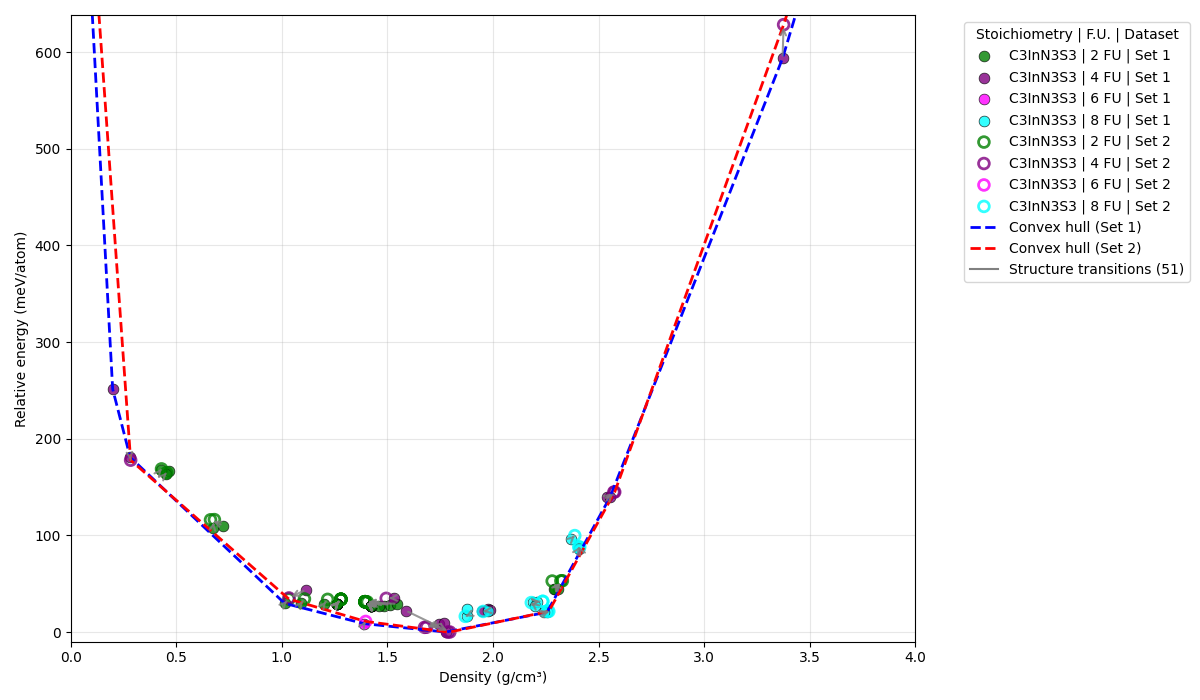

In [3]:
"""Makes the plot to compare two different folders of res files"""
# Configuration
config = Config()
config.relative_energies_on = True
config.apply_cyanurate_filter = True
config.apply_keep_octahedral = False
config.apply_keep_tetrahedral = False
config.apply_keep_layer = False
config.apply_keep_chain = False
config.do_low_energy_file = False
print("hello")
# Set folder path
folder_1 = Path(r"C:\Users\Miles\Documents\Summer research\computing\Convex_hull\Low_energies")
folder_2 = Path(r"C:\Users\Miles\Documents\Summer research\computing\Convex_hull\Low_energy_post_DFT")
#Path(r"C:\Users\Miles\Documents\Summer research\computing\Big energy density graph\low_energies_from_plot")
#Path(r"C:\Users\Miles\Documents\Summer research\computing\Big energy density graph\In[NCS]3")
#Path(r"C:\Users\Miles\Documents\Summer research\computing\Convex_hull\low_energies")
# Create analyzer and process data
analyzer = RESAnalyzer(config)

# try:
print("🚀 Starting optimized analysis...")
start_time = time.time()
# Full_results= analyzer.process_multiple_folders(folders=[folder_1, folder_2])
# results_1 = Full_results.get(folder_1.name, None)
# results_2 = Full_results.get(folder_2.name, None)
results_1 = analyzer.process_folder(folder_1)
results_2 = analyzer.process_folder(folder_2)
total_time = time.time() - start_time
print(f"🎉 Total analysis completed in {total_time} seconds")

if results_1 and results_2:
    file_names_1, densities_1, energies_1, formula_units_1, stoichiometries_1 = results_1
    file_names_2, densities_2, energies_2, formula_units_2, stoichiometries_2 = results_2

    # Create interactive plot
    analyzer.create_comparison_plot(
        file_names_1, energies_1, densities_1, formula_units_1, stoichiometries_1,
        file_names_2, energies_2, densities_2, formula_units_2, stoichiometries_2
    )
else:
    print("No data to plot.")



In [1]:
# Separate Jupyter cell for Energy Density Comparison Plot
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

def plot_filtered_vs_unfiltered_comparison(folder_path, config_filtered, config_unfiltered):
    """
    Create side-by-side plots comparing filtered vs unfiltered energy density data
    
    Parameters:
    -----------
    folder_path : str or Path
        Path to the folder containing .res files
    config_filtered : Config
        Configuration with filters enabled
    config_unfiltered : Config
        Configuration with filters disabled
    """
    
    folder = Path(folder_path)
    
    # Process data with filters
    print("Processing with filters enabled...")
    analyzer_filtered = RESAnalyzer(config_filtered)
    results_filtered = analyzer_filtered.process_folder(folder)
    
    # Process data without filters
    print("\nProcessing with filters disabled...")
    analyzer_unfiltered = RESAnalyzer(config_unfiltered)
    results_unfiltered = analyzer_unfiltered.process_folder(folder)
    
    if not results_filtered or not results_unfiltered:
        print("Error: Could not process data for comparison")
        return
    
    # Unpack results
    file_names_f, densities_f, energies_f, formula_units_f, stoichiometries_f = results_filtered
    file_names_u, densities_u, energies_u, formula_units_u, stoichiometries_u = results_unfiltered
    u= min(energies_u.min(), energies_f.min())
    energies_u -= u
    energies_f -= u
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Define colors for formula units
    fu_colors = {1: 'red', 2: 'green', 3: 'blue', 4: 'purple', 
                 6: 'magenta', 8: 'cyan', 'other': 'black', 'Filtered out': 'orange'}
    
    def plot_data(ax, densities, energies, formula_units, stoichiometries, title):
        """Helper function to plot data on given axis"""
        
        # Group by stoichiometry and formula units
        unique_stoichiometries = sorted(set(stoichiometries))
        markers = ['o', 's', '^', 'D', 'P', 'v', '<', '>', '*', 'X']
        stoich_to_marker = {stoich: markers[i % len(markers)] 
                           for i, stoich in enumerate(unique_stoichiometries)}
        
        # Plot points grouped by stoichiometry and formula units
        for stoich in unique_stoichiometries:
            stoich_mask = stoichiometries == stoich
            
            for fu in sorted(set(formula_units[stoich_mask])):
                fu_mask = formula_units == fu
                combined_mask = stoich_mask & fu_mask
                
                if np.any(combined_mask):
                    color = fu_colors.get(fu, fu_colors['other'])
                    marker = stoich_to_marker[stoich]
                    
                    ax.scatter(densities[combined_mask], energies[combined_mask],
                              marker=marker, color=color, alpha=0.7, s=50,
                              label=f"{stoich} | {fu} FU")
        
        ax.set_xlabel('Density (g/cm³)')
        energy_label = 'Relative Energy (meV/atom)' if config_filtered.relative_energies_on else 'Energy per atom (meV/atom)'
        ax.set_ylabel(energy_label)
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(left=0)  # Ensure x-axis starts at 0
        ax.set_ylim(bottom=-30)  # Ensure y-axis starts just below 0 
        
        # Add legend outside the plot
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), 
                 bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot filtered data
    plot_data(ax1, densities_f, energies_f, formula_units_f, stoichiometries_f, 
              f"Filtered Data\n({len(densities_f)} points)")
    
    # Plot unfiltered data
    plot_data(ax2, densities_u, energies_u, formula_units_u, stoichiometries_u, 
              f"Unfiltered Data\n({len(densities_u)} points)")
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n📊 Comparison Statistics:")
    print(f"Unfiltered points: {len(densities_u)}")
    print(f"Filtered points: {len(densities_f)}")
    print(f"Points removed by filters: {len(densities_u) - len(densities_f)}")
    print(f"Percentage filtered out: {((len(densities_u) - len(densities_f)) / len(densities_u) * 100):.1f}%")
    


def plot_overlay_comparison(folder_path, config_filtered, config_unfiltered):
    """
    Create an overlay plot showing filtered points highlighted on top of all points
    
    Parameters:
    -----------
    folder_path : str or Path
        Path to the folder containing .res files
    config_filtered : Config
        Configuration with filters enabled
    config_unfiltered : Config
        Configuration with filters disabled
    """
    
    folder = Path(folder_path)
    
    # Process data with and without filters
    analyzer_filtered = RESAnalyzer(config_filtered)
    analyzer_unfiltered = RESAnalyzer(config_unfiltered)
    
    results_filtered = analyzer_filtered.process_folder(folder)
    results_unfiltered = analyzer_unfiltered.process_folder(folder)

    
    if not results_filtered or not results_unfiltered:
        print("Error: Could not process data for comparison")
        return
    
    # Unpack results
    file_names_f, densities_f, energies_f, formula_units_f, stoichiometries_f = results_filtered
    file_names_u, densities_u, energies_u, formula_units_u, stoichiometries_u = results_unfiltered
    u= min(energies_u.min(), energies_f.min())
    energies_u -= u
    energies_f -= u
    file_names = file_names_u.copy()
    big_energy = energies_u.copy()
    big_density = densities_u.copy()
    formula_units = np.array([''] * len(file_names_u), dtype='object')
    stoichiometries = stoichiometries_u.copy()
    for i in range(len(file_names_u)):
        if file_names_u[i] in  file_names_f:
            formula_units[i] = formula_units_u[i]
        else:
            formula_units[i] = 'Filtered out'

    analyzer_unfiltered.create_interactive_plot(
        file_names, big_energy, big_density, formula_units, stoichiometries)       


# Example usage:
# Set up your configurations
config_with_filters = Config()
config_with_filters.relative_energies_on = False
config_with_filters.apply_cyanurate_filter =  True # Enable filters
config_with_filters.apply_keep_octahedral = False
config_with_filters.apply_keep_tetrahedral = True
config_with_filters.apply_keep_layer = False
config_with_filters.apply_keep_chain = False
config_with_filters.do_low_energy_file = False

config_without_filters = Config()
config_without_filters.relative_energies_on = False
config_without_filters.apply_cyanurate_filter = False  # Disable filters
config_without_filters.apply_keep_octahedral = False
config_without_filters.apply_keep_tetrahedral = False
config_without_filters.apply_keep_layer = False
config_without_filters.apply_keep_chain = False
config_without_filters.do_low_energy_file = False

# Your folder path
folder_path = r"C:\\Users\\Miles\\Documents\\Summer research\\computing\\Big energy density graph\\In[NCS]3"

# Create side-by-side comparison
#print("Creating side-by-side comparison...")
#plot_filtered_vs_unfiltered_comparison(folder_path, config_with_filters, config_without_filters)

print("\n" + "="*50)

# Create overlay comparison
print("Creating overlay comparison...")
plot_overlay_comparison(folder_path, config_with_filters, config_without_filters)

NameError: name 'Config' is not defined

In [3]:
# File count analysis by stoichiometry and formula units
# Run this cell after running your main analysis

def analyze_file_distribution(stoichiometries, formula_units):
    """Analyze and display file distribution by stoichiometry and formula units"""
    import pandas as pd
    from collections import Counter
    
    # Count files by stoichiometry
    stoich_counts = Counter(stoichiometries)
    
    # Count files by formula units
    fu_counts = Counter(formula_units)
    
    # Combined analysis: stoichiometry + formula units
    combined = [f"{stoich} ({fu} FU)" for stoich, fu in zip(stoichiometries, formula_units)]
    combined_counts = Counter(combined)
    
    print("=" * 60)
    print("FILE DISTRIBUTION ANALYSIS")
    print("=" * 60)
    
    print(f"\nTotal files processed: {len(stoichiometries)}")
    
    # Stoichiometry breakdown
    print(f"\n📊 FILES BY STOICHIOMETRY:")
    print("-" * 40)
    for stoich, count in sorted(stoich_counts.items()):
        percentage = (count / len(stoichiometries)) * 100
        print(f"{stoich:>15}: {count:>4} files ({percentage:5.1f}%)")
    
    # Formula unit breakdown
    print(f"\n📊 FILES BY FORMULA UNITS:")
    print("-" * 40)
    for fu, count in sorted(fu_counts.items()):
        percentage = (count / len(stoichiometries)) * 100
        print(f"{fu:>3} FU: {count:>4} files ({percentage:5.1f}%)")
    
    # Create summary DataFrame
    print(f"\n📋 SUMMARY TABLE:")
    print("-" * 40)
    
    # Create a cross-tabulation
    df_data = []
    for stoich, fu in zip(stoichiometries, formula_units):
        df_data.append({'Stoichiometry': stoich, 'Formula_Units': fu})
    
    df = pd.DataFrame(df_data)
    crosstab = pd.crosstab(df['Stoichiometry'], df['Formula_Units'], margins=True)
    
    print(crosstab)
    
    return stoich_counts, fu_counts, combined_counts

# Usage: Run this after your main analysis
if 'results' in globals() and results is not None:
    file_names, stoichiometries, formula_units, energies = results
    analyze_file_distribution(stoichiometries, formula_units)
else:
    print("❌ No results found. Please run your main analysis first.")
    print("Make sure your main() function returns: file_names, stoichiometries, formula_units, energies")

FILE DISTRIBUTION ANALYSIS

Total files processed: 2153

📊 FILES BY STOICHIOMETRY:
----------------------------------------
       C3InN3S3: 2153 files (100.0%)

📊 FILES BY FORMULA UNITS:
----------------------------------------
  1 FU:  126 files (  5.9%)
  2 FU:  768 files ( 35.7%)
  3 FU:  116 files (  5.4%)
  4 FU:  803 files ( 37.3%)
  6 FU:  205 files (  9.5%)
  8 FU:  135 files (  6.3%)

📋 SUMMARY TABLE:
----------------------------------------
Formula_Units    1    2    3    4    6    8   All
Stoichiometry                                    
C3InN3S3       126  768  116  803  205  135  2153
All            126  768  116  803  205  135  2153


In [4]:
import os
FOLDER = "C:\\Users\\Miles\\Documents\\Summer research\\computing\\Big energy density graph\\In[NCS]3"

# Dictionary to track first occurrence of each filename
seen = {}

for root, dirs, files in os.walk(FOLDER):
    for file in files:
        if file in seen:
            # Duplicate found, delete it
            dup_path = os.path.join(root, file)
            print(f"Deleting duplicate: {dup_path}")
            try:
                os.remove(dup_path)
            except Exception as e:
                print(f"Could not delete {dup_path}: {e}")
        else:
            # First time seeing this filename
            seen[file] = os.path.join(root, file)